# Faraday Dreams Tutorial

Below you can find a tutorial that shows simulation of measurements from a ground truth Faraday depth signal. Then recovery is performed using Optimus Primal. The tutorial shows the impact of channel averaging depolarization at low frequencies, and how it can be recovered.

In [1]:
import sys
sys.path.insert(0,'..')
#put path to optimusprimal git repo
sys.path.insert(0,'../../Optimus-Primal')
import faradaydreams.measurement_operator as measurement_operator
import faradaydreams.models as models
import faradaydreams.recover_faraday_spectra as recover_faraday_spectra
import faradaydreams.convex_solvers as solvers
import numpy as np
import matplotlib.pyplot as plt

This next bit of code sets up the parameters for the observation. The samples in frequency $\nu$, which determine the samples in $\lambda^2$. The big issue here is channgel width $\Delta \nu$ in frequency is constant, but $\Delta \lambda^2$ is not.

In [2]:
c =  299792458.  #speed of light m/s
m_size = 128 #numbr of channels
ISNR = 30. #signal to noise ratio of input noise
freq0 =  np.linspace(400, 800, m_size) * 10**6 # frequency coverage
dfreq = np.abs(freq0[1] - freq0[0]) # channel width
print(f"Channel width is {dfreq/10**6} MHz")
lambda2 = (c/freq0)**2 #wavelength^2 coverage
lambda1 = np.sqrt(lambda2) # wavelength coverage
dlambda2 = (c/(freq0 - dfreq/2.))**2 - (c/(freq0 + dfreq/2.))**2 #channel width in wavelength squared.
phi_max, phi_min, dphi = measurement_operator.phi_parameters(lambda2, dlambda2) #sensitivity estiamtes given coverage
phi = measurement_operator.create_phi_array(320, 2 * dphi)
weights = np.ones(m_size) #choosing flat noise
weights = weights
rm_max = np.min([500, phi_max]) #only for plotting

Channel width is 3.1496062992126346 MHz
2021-10-08 12:55:12,321 - Faraday Dreams - INFO - φ resolution 2.7963945936914554 rad/m^2.
2021-10-08 12:55:12,322 - Faraday Dreams - INFO - φ max range is 904.3549567546503 rad/m^2.
2021-10-08 12:55:12,323 - Faraday Dreams - INFO - φ min range is 113.04174131257713 rad/m^2.


### Constructing the model
Below we construct a ground truth Faraday Depth, this can be delta functions, box functions, or gaussian functions.

In [3]:
x_true = np.zeros(phi.shape) * 0j #zero model of signal

In [4]:
# amplitudes = [1, 2, 4] jy, locations = [-40, 25, 0], polarization angles = [0, np.pi/5, -np.pi/3] radians
x_true += models.deltas(phi, [5, 5], [0, 300], [0, -np.pi/3]) 

In [5]:
# amplitude = 1 jy, width = 10 rad/m^2, location = 50 rad/m^2, polarization angle = 0 radians
#x_true += models.box(phi, 1, 50, 200, 0)

In [6]:
# amplitude = 1 jy, width = 10 rad/m^2, location = 50 rad/m^2, polarization angle = 0 radians
#x_true += models.gaussian(phi, 1, 10, 50, 0)

### Constructing the measurement matrix
The measurement process can be written in the measurement equation
$$P(\lambda^2) = \int P(\phi) a(\lambda^2, \phi) {\rm e}^{2 i \lambda^2 \phi}{\rm d} \phi \, ,$$
which maps Faraday Depth $\phi$ to the measured wavelength $\lambda^2$ for $P = Q +iU$.
The measurement matrix is determined by the following sum: 
$$P(\lambda^2_p) = \sum_{k=0}^N P(\phi_k) a(\lambda^2_p, \phi_k) {\rm e}^{2 i \lambda^2_p \phi_k}\Delta \phi_k$$
where $P$ is the complex polarization signal. $a$ is the impact of channel averaging (it has a constant value of 1 when there is no averaging). It is a Fourier series between $\lambda^2$ and $\phi$.

We can write this as $$\mathbf{y} = \mathbf{\mathsf{\Phi}}\mathbf{x}$$ since it is a system of linear equations.

In [7]:
# measurement operator with channel averaging
m_op_right = measurement_operator.faraday_operator(lambda2, phi, weights, dlambda2)
m_op_wrong = measurement_operator.faraday_operator(lambda2, phi, weights)

Below we also create a version (for comparing no channel averaging) where $a(\lambda^2_p, \phi_k) = 1$

In [8]:
# measurement operator without channel averaging
lambda2_high_res = np.linspace(np.min(lambda2), np.max(lambda2), 1024)
lambda1_high_res = np.sqrt(lambda2_high_res)
m_op_no_averaging = measurement_operator.faraday_operator(lambda2_high_res, phi, lambda2_high_res * 0 + 1)

We calculate our simulated measurements $y$ with added noise.

In [9]:
# simulate measurement process
y0 = m_op_right.dir_op(x_true)

In [10]:
# add iid noise to measurements
sigma = 10**(-ISNR/20.)  * np.linalg.norm(y0) * 1./ np.sqrt(m_size)
y = (y0 + np.random.normal(0, sigma, m_size) + 1j * np.random.normal(0, sigma, m_size))

Below we plot our measured signal in $\lambda^2$ (wavelength squared $m^2$) with and without channel averaging (top panel), and compare the absolute value of the measured signal in $\phi$ (Faraday Depth, rad/m$^2$) against the ground truth (bottom panel). 

The missing Fourier coefficients in $\lambda^2$ make the blue curve very different from the original (yellow).

(-500.0, 500.0)

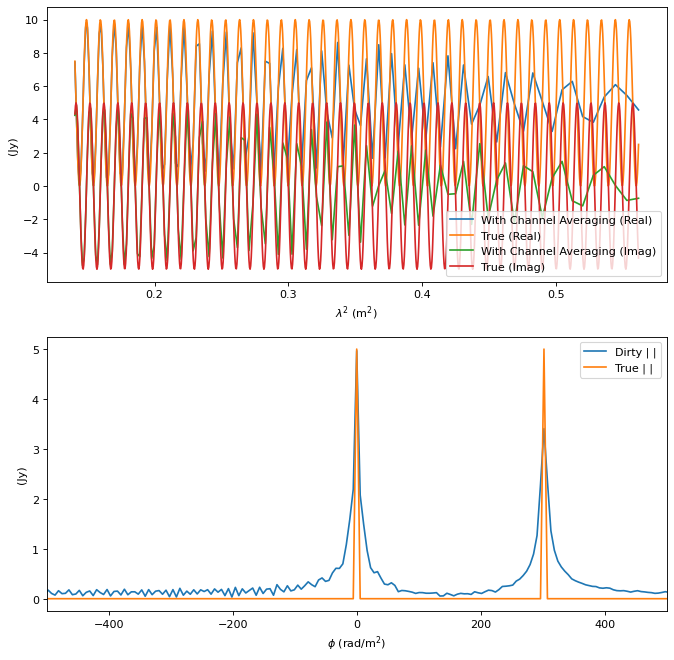

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), dpi=80)
ax[0].plot(lambda2, np.real(y0))
ax[0].plot(lambda2_high_res, np.real(m_op_no_averaging.dir_op(x_true)))
ax[0].plot(lambda2, np.imag(y0))
ax[0].plot(lambda2_high_res, np.imag(m_op_no_averaging.dir_op(x_true)))

ax[0].set_xlabel(r"$\lambda^2$ (m$^2$)")
ax[0].set_ylabel(r"(Jy)")
ax[0].legend(["With Channel Averaging (Real)", "True (Real)", "With Channel Averaging (Imag)", "True (Imag)"])
ax[1].plot(phi, np.abs(m_op_right.adj_op(y)) * 1./len(y))
ax[1].plot(phi, np.abs(x_true))
ax[1].legend(["Dirty | |", "True | |", "Solution | |"])
ax[1].set_xlabel(r"$\phi$ (rad/m$^2$)")
ax[1].set_ylabel(r"(Jy)")
ax[1].set_xlim([-rm_max, rm_max])

Below you can choose assumptions about how to fit the true signal. You can choose wavelets or not (dirac is no wavelets). I suggest no wavelets for now

In [12]:
options = {'tol': 1e-4, 'iter': 50000, 'update_iter': 1000, 'record_iters': False, 'project_positive_lambda2': False}
beta= 1e-3 #stepsize that you might have to change 1e-2 to 1e-4 are normally okay, change if result looks bad
results_with_correction = recover_faraday_spectra.recover_1d_faraday_spectrum(Q=np.real(y), U=np.imag(y), error_Q=1/weights/np.sqrt(2), error_U=1/weights/np.sqrt(2), freq=freq0, dphi=2 * dphi, Nphi=320,
                                                                                     sigma_factor=sigma, beta=beta, options=options, channel_widths=dfreq)
results_without_correction = recover_faraday_spectra.recover_1d_faraday_spectrum(Q=np.real(y), U=np.imag(y), error_Q=weights/np.sqrt(2), error_U=weights/np.sqrt(2), freq=freq0, dphi=2 * dphi, Nphi=320,
                                                                                     sigma_factor=sigma, beta=beta, options=options, channel_widths=None)

2021-10-08 12:55:12,925 - Optimus Primal - INFO - Starting Power method
2021-10-08 12:55:12,926 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2021-10-08 12:55:12,928 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2021-10-08 12:55:12,930 - Optimus Primal - INFO - [Power Method] iter = 21, tol = 0.0
2021-10-08 12:55:12,933 - Optimus Primal - INFO - [Power Method] iter = 31, tol = 0.0
2021-10-08 12:55:12,936 - Optimus Primal - INFO - [Power Method] iter = 41, tol = 0.0
2021-10-08 12:55:12,937 - Optimus Primal - INFO - [Power Method] Converged with norm= 485.7945611619789, iter = 48, tol = 9.38918080453065e-05
2021-10-08 12:55:12,938 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 1 levels
2021-10-08 12:55:12,938 - Faraday Dreams - INFO - Using an estimated noise level of 0.20465859513802334 (Jy)
2021-10-08 12:55:12,939 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2021-10-08 12:55:12,940 - Optimus Primal - 

Below we calculate some comparisons to plot against the model. This involes ground truth, measured, and fitted model.

In [13]:
y_right = m_op_right.dir_op(results_with_correction['solution']) * freq0/freq0[0]
y_wrong = m_op_wrong.dir_op(results_without_correction['solution']) * freq0/freq0[0]
y_true = m_op_no_averaging.dir_op(x_true)
y_model_right = m_op_no_averaging.dir_op(results_with_correction['solution']) 
y_model_wrong = m_op_no_averaging.dir_op(results_without_correction['solution']) 

(-100.0, 100.0)

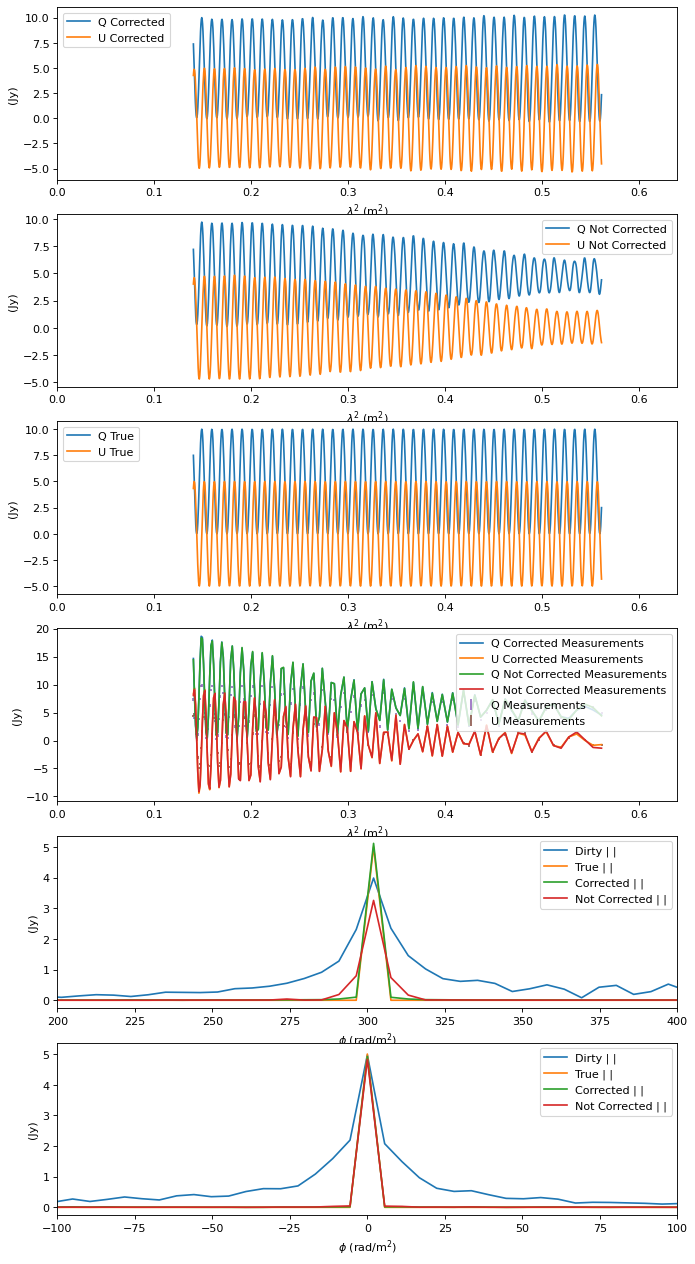

In [14]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(10, 20), dpi=80)
ax[0].plot(lambda2_high_res, np.real(y_model_right))
ax[0].plot(lambda2_high_res, np.imag(y_model_right))
ax[1].plot(lambda2_high_res, np.real(y_model_wrong))
ax[1].plot(lambda2_high_res, np.imag(y_model_wrong))
ax[2].plot(lambda2_high_res, np.real(m_op_no_averaging.dir_op(x_true)))
ax[2].plot(lambda2_high_res, np.imag(m_op_no_averaging.dir_op(x_true)))
ax[0].set_xlim([0., 0.8**2])
ax[1].set_xlim([0., 0.8**2])
ax[2].set_xlim([0., 0.8**2])
ax[0].set_xlabel(r"$\lambda^2$ (m$^2$)")
ax[0].set_ylabel(r"(Jy)")
ax[1].set_xlabel(r"$\lambda^2$ (m$^2$)")
ax[1].set_ylabel(r"(Jy)")
ax[2].set_xlabel(r"$\lambda^2$ (m$^2$)")
ax[2].set_ylabel(r"(Jy)")
ax[0].legend(["Q Corrected", "U Corrected"])
ax[1].legend(["Q Not Corrected", "U Not Corrected"])
ax[2].legend(["Q True", "U True"])
ax[3].plot(lambda2, np.real(y_right))
ax[3].plot(lambda2, np.imag(y_right))
ax[3].plot(lambda2, np.real(y_wrong))
ax[3].plot(lambda2, np.imag(y_wrong))
ax[3].errorbar(lambda2, np.real(y), yerr=lambda2*0 + sigma, fmt='',linestyle='')
ax[3].errorbar(lambda2, np.imag(y), yerr=lambda2*0 + sigma, fmt='',linestyle='')
ax[3].set_xlim([0., 0.8**2])
ax[3].set_xlabel(r"$\lambda^2$ (m$^2$)")
ax[3].set_ylabel(r"(Jy)")
ax[3].legend(["Q Corrected Measurements", "U Corrected Measurements", "Q Not Corrected Measurements", "U Not Corrected Measurements","Q Measurements", "U Measurements",])
ax[4].plot(phi, np.abs(m_op_wrong.adj_op(y)) * 1./len(y))
ax[4].plot(phi, np.abs(x_true))
ax[4].plot(phi, np.abs(results_with_correction['solution']))
ax[4].plot(phi, np.abs(results_without_correction['solution']))
ax[4].legend(["Dirty | |", "True | |", "Corrected | |", "Not Corrected | |"])
ax[4].set_xlabel(r"$\phi$ (rad/m$^2$)")
ax[4].set_ylabel(r"(Jy)")
ax[4].set_xlim([200, 400])
ax[5].plot(phi, np.abs(m_op_right.adj_op(y)) * 1./len(y))
ax[5].plot(phi, np.abs(x_true))
ax[5].plot(phi, np.abs(results_with_correction['solution']))
ax[5].plot(phi, np.abs(results_without_correction['solution']))
ax[5].legend(["Dirty | |", "True | |", "Corrected | |", "Not Corrected | |"])
ax[5].set_xlabel(r"$\phi$ (rad/m$^2$)")
ax[5].set_ylabel(r"(Jy)")
ax[5].set_xlim([-100, 100])

The example above shows that the high RM signal undergoes depolarization due to channel averaging, however this can be corrected during reconstruction.

The zero RM signal is not affected by channel averaging, and there is no difference before and after correction.